In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from networks import fcn_isotropic
import scipy
import torch.nn as nn

np.random.seed(42)
torch.manual_seed(42)

In [2]:
data = np.load(r'/Users/jaworskj/Desktop/Pulse_data_sample/Synthetic_data/Uniform_heating/Batch_1/2025.06.27 - param_study_fbh_size_depth_thickness/param_fbh_size10mm_depth30pct_thickness6mm/param_fbh_size10mm_depth30pct_thickness6mm.npz', allow_pickle=True)

In [3]:
# emissivity of the sample 
k=2 # W/(mK)
q=1600 # kg/m^3
Cp=700 # J/(kgK)

a=k/(q*Cp)
print(f'Thermal diffusivity value: {a} m2/s')

Thermal diffusivity value: 1.7857142857142857e-06 m2/s


In [4]:
data = np.array(data['data'], dtype=np.float32)
data=torch.from_numpy(data)
data.dtype

torch.float32

In [5]:
data.size()

torch.Size([634, 512, 512])

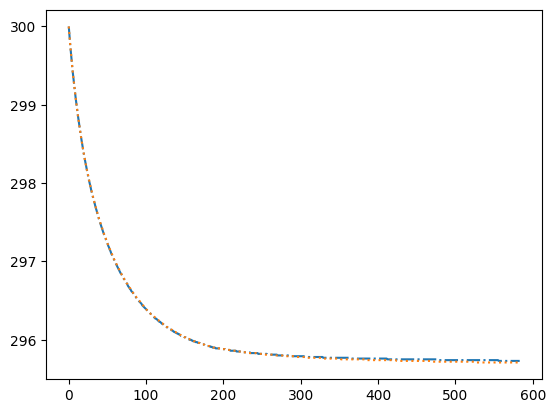

In [6]:
T,Y,X=data.shape
y_center=Y//2
x_center=X//2

plt.plot(data[50:,y_center,x_center]+273.15,linestyle='-.')
plt.plot(data[50:,y_center+100,x_center+100]+273.15,linestyle=':')
# plt.plot(data[50:,y_center-100,x_center-100]+273.15,linestyle='-.')


In [7]:
activation_function=nn.Tanh()
x=torch.linspace(-5,5,100,requires_grad=True)
result=activation_function(x)
result.backward(torch.ones_like(x))

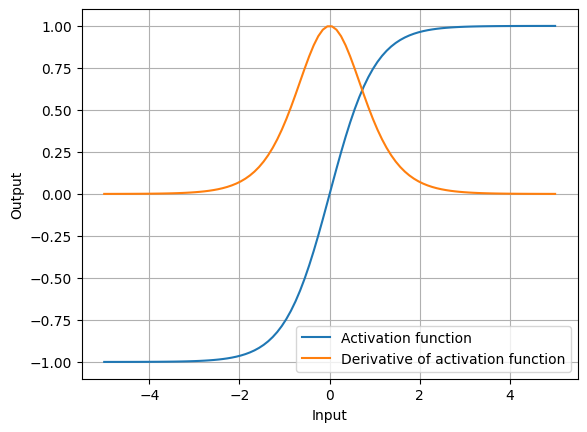

In [8]:
plt.plot(x.detach(),activation_function(x).detach(),label='Activation function')
plt.plot(x.detach(),x.grad.detach(),label='Derivative of activation function')
plt.grid(0.3)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()


In [9]:
p_data=data+273.15
p_data=p_data[4:,:,:]
p_data.shape

torch.Size([630, 512, 512])

In [ ]:
t = torch.linspace(0, 21, 630)     # shape (630,)
y = torch.linspace(0, 0.1, 512)    # shape (512,)
x = torch.linspace(0, 0.1, 512)    # shape (512,)

t, y, x = torch.meshgrid(t, y, x, indexing='ij')

# We need to concatenate column vectors
coordis = torch.cat([
    t.reshape(-1, 1),
    y.reshape(-1, 1),
    x.reshape(-1, 1)
], dim=1)

print(t.shape)        # (630, 512, 512)
print(coordis.shape)  # (164229120, 3)


torch.Size([630, 512, 512])
torch.Size([165150720, 3])
